In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy.ndimage import measurements
from skimage.morphology import label

from z3 import *

In [2]:
def reset(positions):
    min_x, min_y = min(positions, key=lambda x:x[::-1])
    return tuple(sorted((x-min_x, y-min_y) for x, y in positions))

def variation(positions):
    return list({reset(var) for var in (
        positions,
        [(-y,  x) for x, y in positions], # Anti-clockwise 90
        [(-x, -y) for x, y in positions], # 180
        [( y, -x) for x, y in positions], # Clockwise 90

        [(-x,  y) for x, y in positions], # Mirror vertical
        [(-y, -x) for x, y in positions], # Mirror diagonal
        [( x, -y) for x, y in positions], # Mirror horizontal
    )})

def orientation(x,y,shape,A,B):
    for (alpha,beta) in shape:
        links = []
        for (i,j) in shape:
            if (i,j) !=(alpha,beta):
                if  (x+i-alpha >= 0) & (x+i-alpha <A) & (y+j-beta >=0) &  (y+j-beta <B):
                     links.append((x+i-alpha,y+j-beta))
    
            if len(links) == len(shape)-1:
                yield links
            
def forced(x,y,A,B,n):
    shapes = [
    (((0, 1), (1, 0), (1, 1), (1, 2), (2, 0)), "F"),
    (((0, 0), (0, 1), (0, 2), (0, 3), (0, 4)), "I"),
    (((0, 0), (0, 1), (0, 2), (0, 3), (1, 3)), "L"),
    (((0, 2), (0, 3), (1, 0), (1, 1), (1, 2)), "N"),
    (((0, 0), (0, 1), (0, 2), (1, 0), (1, 1)), "P"),
    (((0, 0), (1, 0), (1, 1), (1, 2), (2, 0)), "T"),
    (((0, 0), (0, 1), (1, 1), (2, 0), (2, 1)), "U"),
    (((0, 0), (0, 1), (0, 2), (1, 2), (2, 2)), "V"),
    (((0, 0), (0, 1), (1, 1), (1, 2), (2, 2)), "W"),
    (((0, 1), (1, 0), (1, 1), (1, 2), (2, 1)), "X"),
    (((0, 1), (1, 0), (1, 1), (1, 2), (1, 3)), "Y"),
    (((0, 0), (1, 0), (1, 1), (1, 2), (2, 2)), "Z")
    ]

    shape_variations = {shape: variation(shape) for shape, name in [shapes[n-1]]}

    for key,vals in shape_variations.items():
        poss = []
        for val in vals:
            poss += [*orientation(x,y,val,A,B)]
    
        return poss

def place(x,y,n,X,N):
    return Or([
        And([X[i,j]==n for i,j in force]) 
        for force in forced(x,y,N[0],N[1],n)
            ])


In [3]:
def fill(N,blank=[],use_lia = False):
    start = time.time()
    
    if use_lia:
        s = Tactic('qflia').solver()
    else:
        s = Tactic('default').solver()
    
    
    X = np.array([[Int("X_%s%s" % (i+1,j+1)) for j in range(N[1]) ] for i in range(N[0]) ],dtype=object)

    # force blank/non-blank
    s += [X[i,j] == 0 if (i,j) in blank else X[i,j] !=0 for j in range(N[1]) for i in range(N[0]) ]

    # the big one. Set the placements round a given cell for each pentomino
    s += [Implies(X[i,j] == n,place(i,j,n,X,N)) for n in range(1,13) for j in range(N[1]) for i in range(N[0])]

    #limit the cells to 0 (blank) or 1-12 (pentomino)
    s += [Or([X[i,j]==n for n in range(0,13)]) for j in range(N[1]) for i in range(N[0]) ]

    #either 5 or 0 of each number
    s += [Or(PbEq([(X[i,j]==n,1) for j in range(N[1]) for i in range(N[0])],5),
         PbEq([(X[i,j]==n,1) for j in range(N[1]) for i in range(N[0])],0))
         for n in range(1,13)]


    print("SETUP DONE .. in {:0.4f} seconds".format(time.time()-start))
    if s.check() == sat:
        m = s.model()
        x = np.array([[m.evaluate(X[i,j]).as_long() for j in range(N[1])] for i in range(N[0])])
        fig,ax = plt.subplots(1,1,figsize=(N[1]/2,N[0]/2)) 
        y = np.array(x).astype('int').astype('str')
        shapes = [' ','F', 'I', 'L', 'N', 'P', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
        mapping = np.vectorize(lambda x:shapes[x])
        shading = mapping(x)
        sns.heatmap(x,annot=shading,cbar=False,cmap="gist_ncar_r",fmt="",linewidths=1,linecolor="grey",annot_kws={"size":12},vmin=0,vmax=12)
        ax.axis("off")
        plt.show()
        #print(s.statistics())
    print('Solution took {:0.4f} seconds'.format(time.time()-start))

SETUP DONE .. in 0.4747 seconds


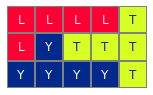

Solution took 0.5825 seconds
SETUP DONE .. in 0.4598 seconds


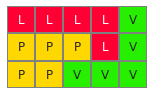

Solution took 0.7550 seconds


In [4]:
N= [3,5]
fill(N)
fill(N,use_lia=True)

SETUP DONE .. in 3.8577 seconds


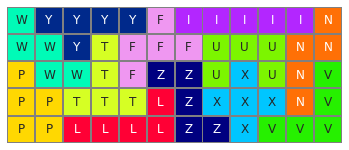

Solution took 7.7673 seconds


In [5]:
N= [5,12]
fill(N)

SETUP DONE .. in 4.3753 seconds


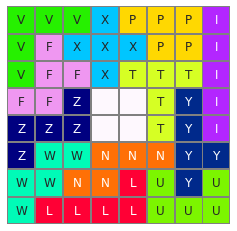

Solution took 5.0774 seconds


In [6]:
N= [8,8]
blank = [(3, 3), (3, 4), (4, 3), (4, 4)]
fill(N,blank)

SETUP DONE .. in 4.3795 seconds


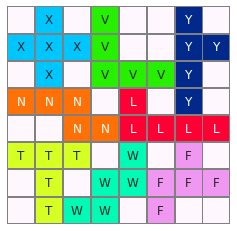

Solution took 4.6510 seconds


In [7]:
N= [8,8]
blank = [(0,0),(0,2),(0,4),(0,5),(0,7),
 (1,4),(1,5),
 (2,0),(2,2),(2,7),
 (3,3),(3,5),(3,7),
 (4,0),(4,1),
 (5,3),(5,5),(5,7),
 (6,0),(6,2),
 (7,0),(7,4),(7,6),(7,7)]

fill(N,blank)

SETUP DONE .. in 1.1529 seconds


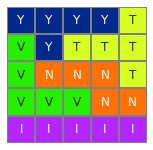

Solution took 1.2862 seconds


In [8]:
N= [5,5]
fill(N)

SETUP DONE .. in 0.3930 seconds


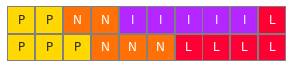

Solution took 0.4857 seconds


In [9]:
N= [2,10]
fill(N)